In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [2]:
import warnings
# Suppress specific warning
warnings.filterwarnings('ignore')

# Exploratory Data Analysis (EDA) : transcations_data

### Key Observations:

#### General Observations
- **Columns**: `amount`, Currently stored as strings with `$`, require cleaning and conversion.
- use_chip: Standardized use_chip values to boolean.
- client_id: id from user_data and client_id from transcation are same
- merchant_category and merchant_id : Capturing the information about the transcation categories
- No missing values found.Contains 1141312 entries 


In [3]:
# Load the datasets
transactions_data_path = './data/transactions_data.csv'

transactions_data = pd.read_csv(transactions_data_path)


# Display the first few rows of each dataset
transactions_data_preview = transactions_data.head()
transactions_data_info = transactions_data.info()


transactions_data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141312 entries, 0 to 1141311
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   id                 1141312 non-null  int64 
 1   date               1141312 non-null  object
 2   client_id          1141312 non-null  int64 
 3   amount             1141312 non-null  object
 4   use_chip           1141312 non-null  object
 5   merchant_id        1141312 non-null  int64 
 6   merchant_category  1141312 non-null  object
dtypes: int64(3), object(4)
memory usage: 61.0+ MB


In [4]:
if transactions_data.duplicated().any():
    print("Duplicate rows exists in the transactions_data.")
    print("\nDuplicate rows:")
    print(df[df.duplicated()])
else:
    print("No duplicate rows in the transactions_data.")

No duplicate rows in the transactions_data.


In [5]:
transactions_data_preview

,id,date,client_id,amount,use_chip,merchant_id,merchant_category
0,22326462,2019-01-01 00:02:00,496,$119.35,Chip Transaction,30286,Telecommunication Services
1,22326465,2019-01-01 00:05:00,1129,$100.00,Chip Transaction,27092,Money Transfer
2,22326466,2019-01-01 00:06:00,114,$51.71,Chip Transaction,61195,Service Stations
3,22326467,2019-01-01 00:06:00,641,$105.30,Swipe Transaction,75781,"Grocery Stores, Supermarkets"
4,22326468,2019-01-01 00:10:00,114,$82.00,Chip Transaction,61195,Service Stations


## EDA : Data Pre Processing for amount and use_chip

In [6]:
data_cleaned = transactions_data.copy()
data_cleaned['amount'] = transactions_data['amount'].replace('[\$,]', '', regex=True).astype(float)

In [7]:
print(transactions_data['use_chip'].unique())

['Chip Transaction' 'Swipe Transaction' 'Online Transaction']


In [8]:
use_chip_one_hot = pd.get_dummies(data_cleaned['use_chip'], prefix='', prefix_sep='')
data_cleaned['use_chip_one_hot'] = use_chip_one_hot.astype(str).agg(''.join, axis=1)

# Convert `use_chip` to one-hot encoding
#use_chip_one_hot = pd.get_dummies(data_cleaned['use_chip'], prefix='use_chip')

# Add the one-hot encoded columns to the original DataFrame
#data_cleaned = pd.concat([data_cleaned, use_chip_one_hot], axis=1)

# Standardize `use_chip` to boolean values
data_cleaned['use_chip_boolean'] = data_cleaned['use_chip'].apply(lambda x: x == 'Chip Transaction')

scaler = RobustScaler()
data_cleaned['robust_normalized_amount'] = scaler.fit_transform(data_cleaned[['amount']])

data_cleaned.head(5)

,id,date,client_id,amount,use_chip,merchant_id,merchant_category,use_chip_one_hot,use_chip_boolean,robust_normalized_amount
0,22326462,2019-01-01 00:02:00,496,119.35,Chip Transaction,30286,Telecommunication Services,TrueFalseFalse,True,1.689033
1,22326465,2019-01-01 00:05:00,1129,100.00,Chip Transaction,27092,Money Transfer,TrueFalseFalse,True,1.329368
2,22326466,2019-01-01 00:06:00,114,51.71,Chip Transaction,61195,Service Stations,TrueFalseFalse,True,0.431784
3,22326467,2019-01-01 00:06:00,641,105.30,Swipe Transaction,75781,"Grocery Stores, Supermarkets",FalseFalseTrue,False,1.427881
4,22326468,2019-01-01 00:10:00,114,82.00,Chip Transaction,61195,Service Stations,TrueFalseFalse,True,0.994796


In [9]:
data_cleaned['amount'].describe()

count    1.141312e+06
mean     4.237273e+01
std      8.081434e+01
min     -5.000000e+02
25%      8.770000e+00
50%      2.848000e+01
75%      6.257000e+01
max      6.613440e+03
Name: amount, dtype: float64

# EDA : Univariate Analysis

### Transaction Amount Analysis

The original distribution is highly skewed to the right, with:
- A large number of transactions clustered around small positive values.
- Very few large transaction sizes (outliers), up to approximately **$6613.44**.
- Negative transaction amounts (like **-\$500.00**) possibly representing refunds or adjustments


#### Key Insights:
- The **average transaction size** (**$42.37**) is marked by the red dashed line and is heavily influenced by the outliers.
- Due to the extreme values, most of the data appears compressed near zero, making it difficult to visualize smaller differences.


Average Transaction Size: $42.37
Minimum Transaction Size: $-500.0
Maximum Transaction Size: $6613.44


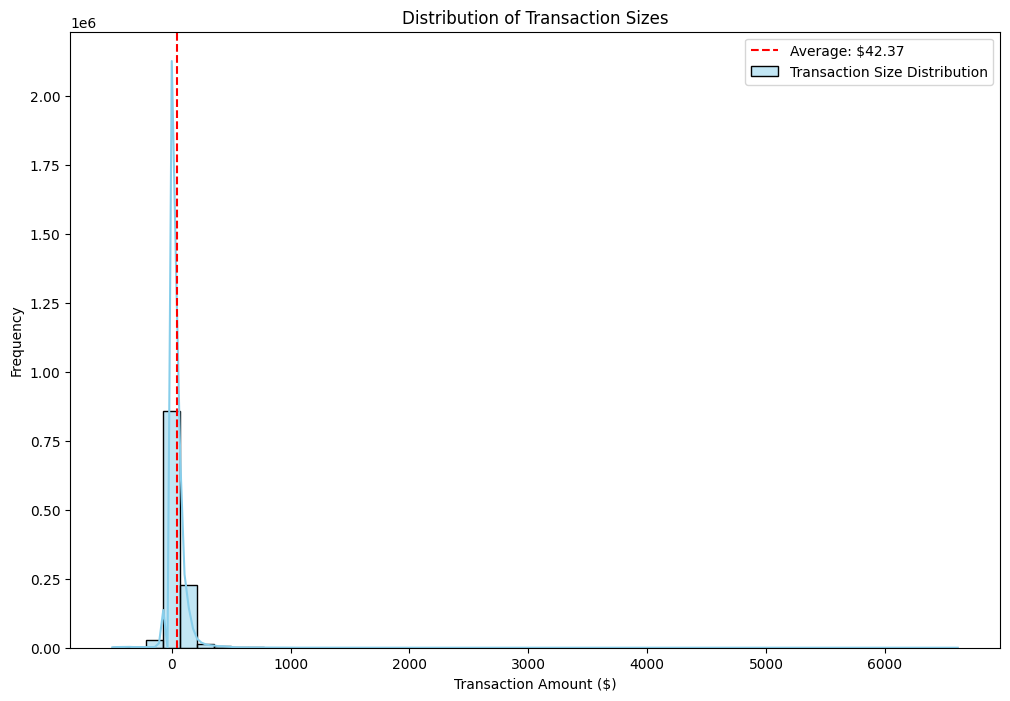

In [10]:

# Function to analyze average transaction size and distribution
def analyze_transaction_size(data):
    # Calculate the average transaction size
    avg_transaction_size = data['amount'].mean()
    min_transaction_size = data['amount'].min()
    max_transaction_size = data['amount'].max()

    print(f"Average Transaction Size: ${avg_transaction_size:.2f}")
    print(f"Minimum Transaction Size: ${min_transaction_size}")
    print(f"Maximum Transaction Size: ${max_transaction_size}")

    # Plot the distribution of transaction amounts
    plt.figure(figsize=(12, 8))
    
    # Histogram for transaction size distribution
    sns.histplot(data['amount'], kde=True, bins=50, color='skyblue', label='Transaction Size Distribution')
    plt.axvline(avg_transaction_size, color='red', linestyle='--', label=f'Average: ${avg_transaction_size:.2f}')
    plt.title('Distribution of Transaction Sizes')
    plt.xlabel('Transaction Amount ($)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
# Call the function with the transactions_data
analyze_transaction_size(data_cleaned)


### How aften chips used in transactions (use_chip)?

The bar plot will show the most frequent categories.

Chip Usage (True: Chip used, False: Chip not used):
use_chip
Chip Transaction      810656
Swipe Transaction     193925
Online Transaction    136731
Name: count, dtype: int64


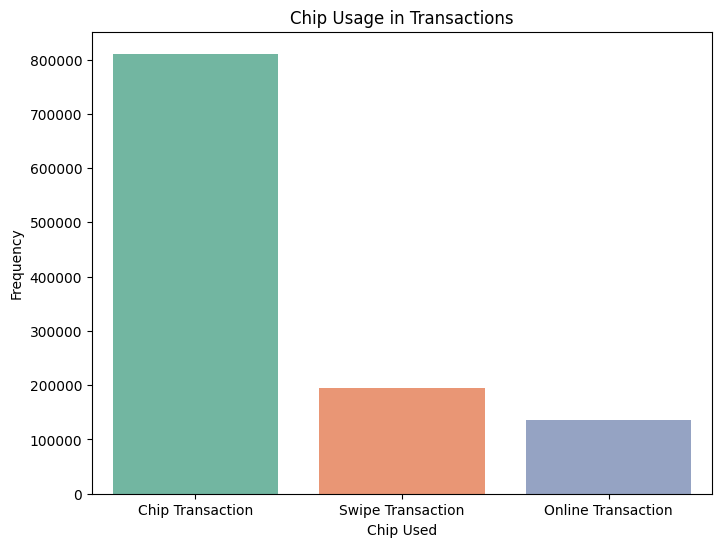

In [11]:
# Function to analyze how often chips are used in transactions
def analyze_chip_usage(data):
    # Calculate the frequency of chip usage (True/False)
    chip_usage_counts = data['use_chip'].value_counts()

    chip_tr = data['use_chip'].unique()
    # Display the frequency of chip usage
    print(f"Chip Usage (True: Chip used, False: Chip not used):")
    print(chip_usage_counts)
    
    # Plot the chip usage frequency
    plt.figure(figsize=(8, 6))
    sns.barplot(x=chip_usage_counts.index, y=chip_usage_counts.values, palette='Set2')
    plt.title('Chip Usage in Transactions')
    plt.xlabel('Chip Used')
    plt.ylabel('Frequency')
    plt.xticks(chip_tr)
    plt.show()

# Call the function with the transactions_data
analyze_chip_usage(data_cleaned)

## What are the most common categories (merchant_category) for transactions?

### Category Distribution

The bar plot will show the most frequent categories.

#### Common Categories:
- You’ll be able to identify which merchant categories (e.g., **Food**, **Grocery**) are most common in the transactions.


Top Merchant Categories:
merchant_category
Grocery Stores, Supermarkets     137314
Miscellaneous Food Stores        124802
Service Stations                 121065
Eating Places and Restaurants     85978
Drug Stores and Pharmacies        65713
Tolls and Bridge Fees             60461
Wholesale Clubs                   50810
Money Transfer                    48943
Taxicabs and Limousines           45049
Fast Food Restaurants             43055
Name: count, dtype: int64


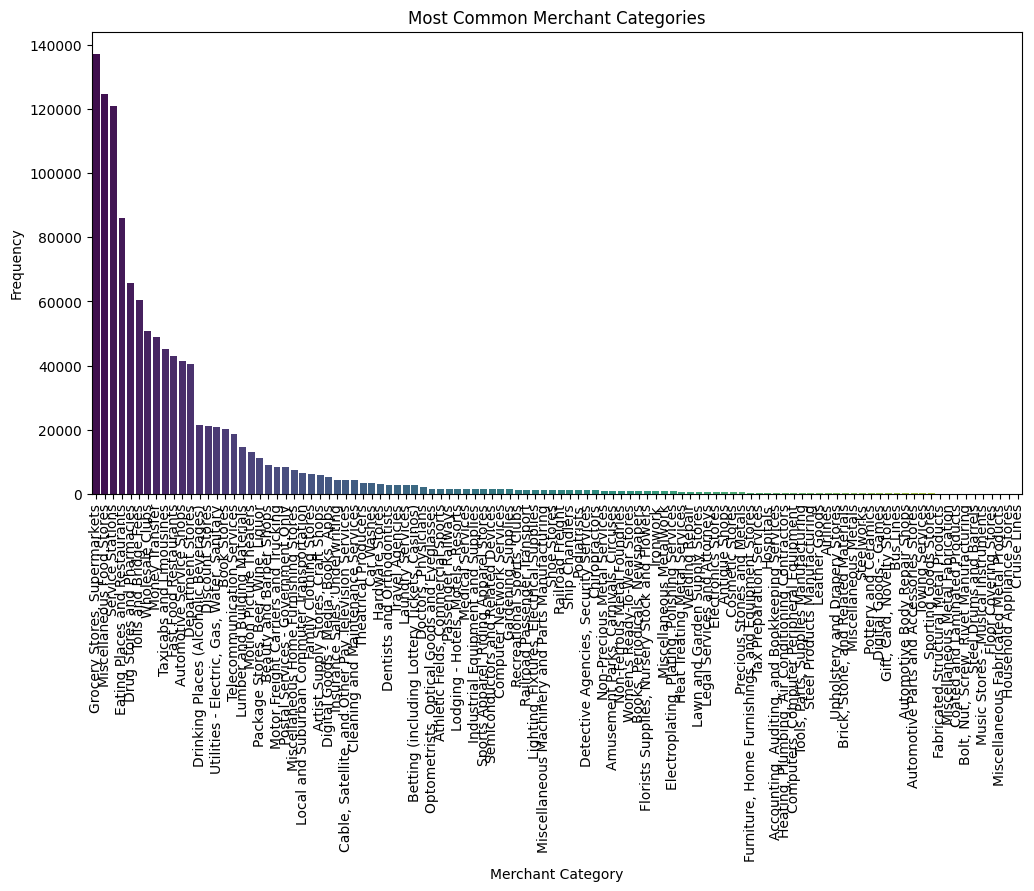

In [12]:
# Function to analyze the most common merchant categories
def analyze_merchant_categories(data):
    # Calculate the frequency distribution of merchant categories
    category_counts = data['merchant_category'].value_counts()

    # Display the top categories
    print("Top Merchant Categories:")
    print(category_counts.head(10))  # Show top 10 most common categories
    
    # Plot the most common categories
    plt.figure(figsize=(12, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
    plt.title('Most Common Merchant Categories')
    plt.xlabel('Merchant Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Call the function with the transactions_data
analyze_merchant_categories(data_cleaned)


#### Common Categories:
- You’ll be able to identify which merchant categories (e.g., **Food**, **Grocery**) are most common in the transactions.

Top Merchant Categories:
merchant_category
Grocery Stores, Supermarkets     137314
Miscellaneous Food Stores        124802
Service Stations                 121065
Eating Places and Restaurants     85978
Drug Stores and Pharmacies        65713
Tolls and Bridge Fees             60461
Wholesale Clubs                   50810
Money Transfer                    48943
Taxicabs and Limousines           45049
Fast Food Restaurants             43055
Name: count, dtype: int64


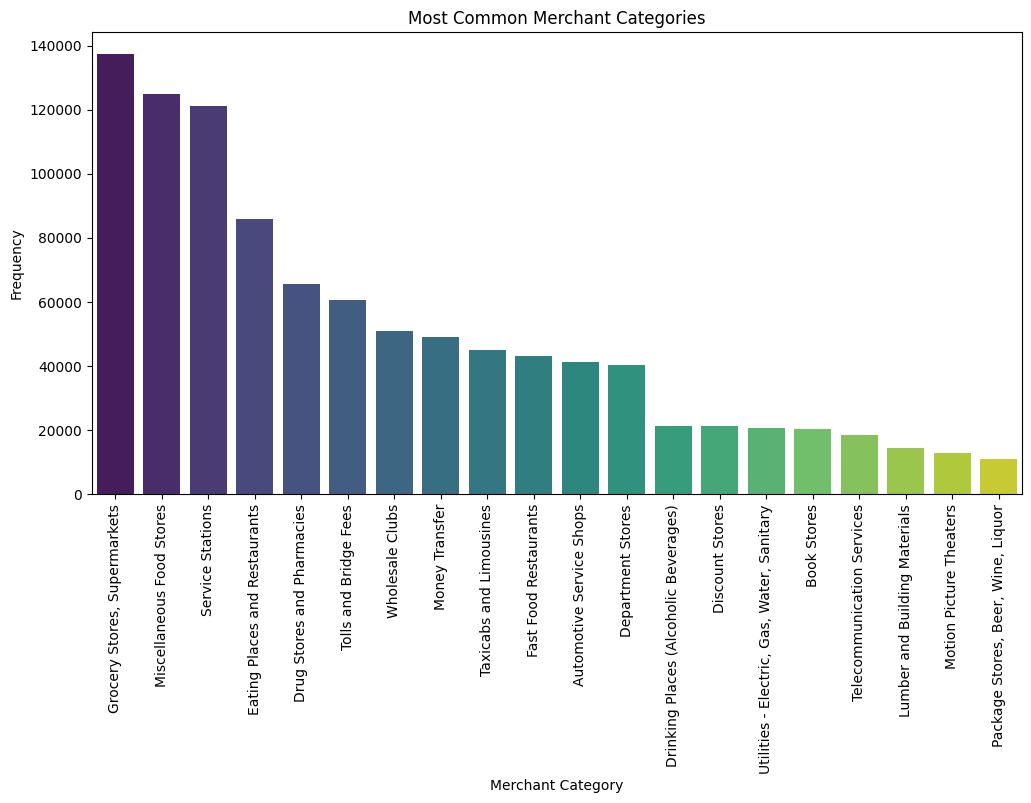

In [13]:
# Count the frequency of each merchant_category
category_counts = data_cleaned['merchant_category'].value_counts()

# Filter categories with frequency greater than 1,000
categories_above_50000 = category_counts[category_counts > 10000]

filtered_data = data_cleaned[data_cleaned['merchant_category'].isin(categories_above_50000.index)]

analyze_merchant_categories(filtered_data)


In [14]:
filtered_data.head(5)

,id,date,client_id,amount,use_chip,merchant_id,merchant_category,use_chip_one_hot,use_chip_boolean,robust_normalized_amount
0,22326462,2019-01-01 00:02:00,496,119.35,Chip Transaction,30286,Telecommunication Services,TrueFalseFalse,True,1.689033
1,22326465,2019-01-01 00:05:00,1129,100.00,Chip Transaction,27092,Money Transfer,TrueFalseFalse,True,1.329368
2,22326466,2019-01-01 00:06:00,114,51.71,Chip Transaction,61195,Service Stations,TrueFalseFalse,True,0.431784
3,22326467,2019-01-01 00:06:00,641,105.30,Swipe Transaction,75781,"Grocery Stores, Supermarkets",FalseFalseTrue,False,1.427881
4,22326468,2019-01-01 00:10:00,114,82.00,Chip Transaction,61195,Service Stations,TrueFalseFalse,True,0.994796


# EDA : Multivariate Analysis

## How does the amount vary across merchant_category?

Average Transaction Amount by Merchant Category:
merchant_category
Utilities - Electric, Gas, Water, Sanitary    113.379000
Telecommunication Services                    112.584018
Money Transfer                                 90.550232
Wholesale Clubs                                61.696595
Department Stores                              56.184354
Automotive Service Shops                       51.996277
Lumber and Building Materials                  45.490640
Drug Stores and Pharmacies                     45.014206
Discount Stores                                40.779116
Tolls and Bridge Fees                          35.857930
Motion Picture Theaters                        26.990182
Fast Food Restaurants                          26.284628
Eating Places and Restaurants                  26.004289
Drinking Places (Alcoholic Beverages)          25.440906
Grocery Stores, Supermarkets                   25.330043
Taxicabs and Limousines                        23.799553
Service Stations     

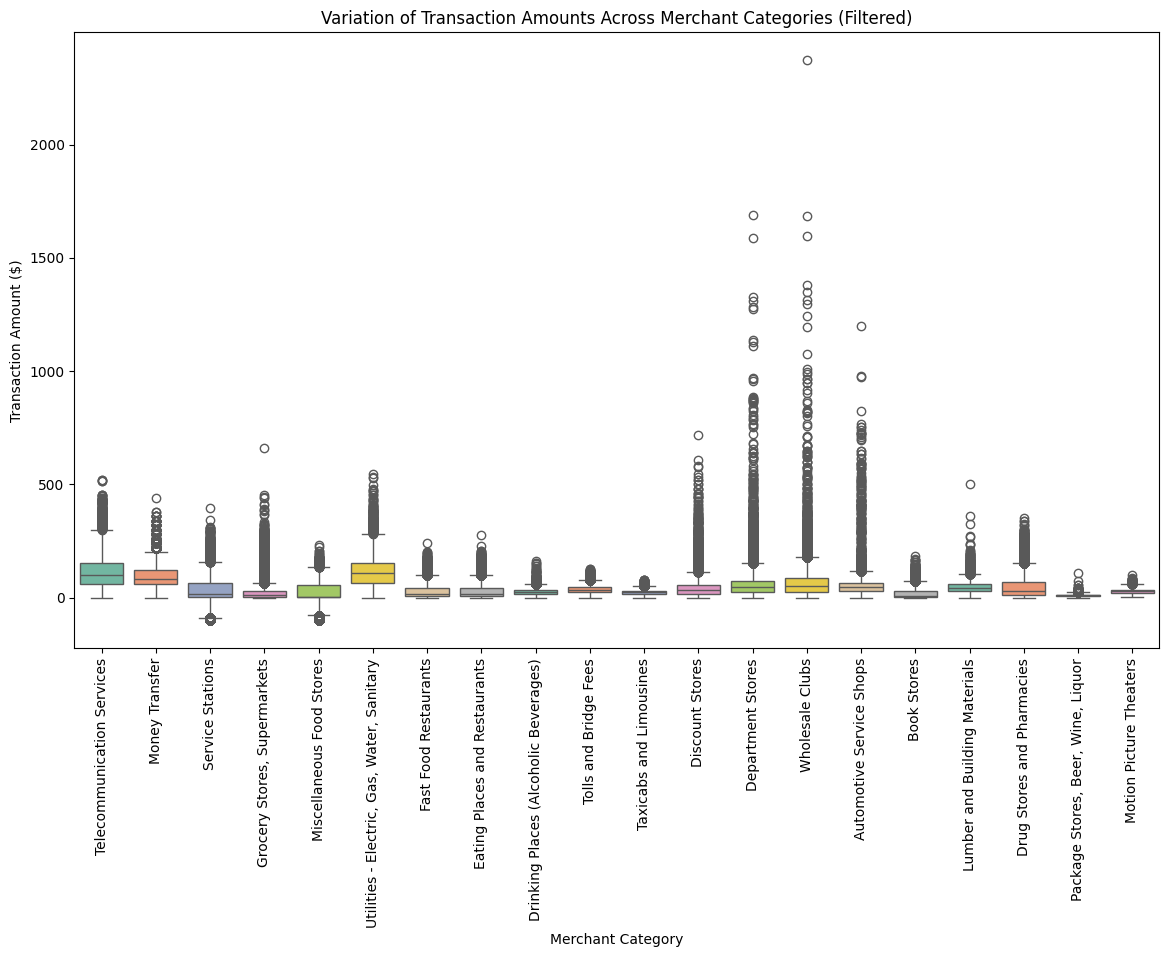

In [15]:
# Function to analyze how the amount varies across merchant_category
def analyze_amount_by_category(data):
    # Calculate the average transaction amount for each merchant category
    avg_amount_by_category = data.groupby('merchant_category')['amount'].mean().sort_values(ascending=False)

    print("Average Transaction Amount by Merchant Category:")
    print(avg_amount_by_category)
    
    # Plot the variation of amount across merchant categories
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='merchant_category', y='amount', data=data, palette='Set2')
    plt.title('Variation of Transaction Amounts Across Merchant Categories (Filtered)')
    plt.xlabel('Merchant Category')
    plt.ylabel('Transaction Amount ($)')
    plt.xticks(rotation=90)
    plt.show()

# Call the function with the filtered data
analyze_amount_by_category(filtered_data)

(165961, 11)


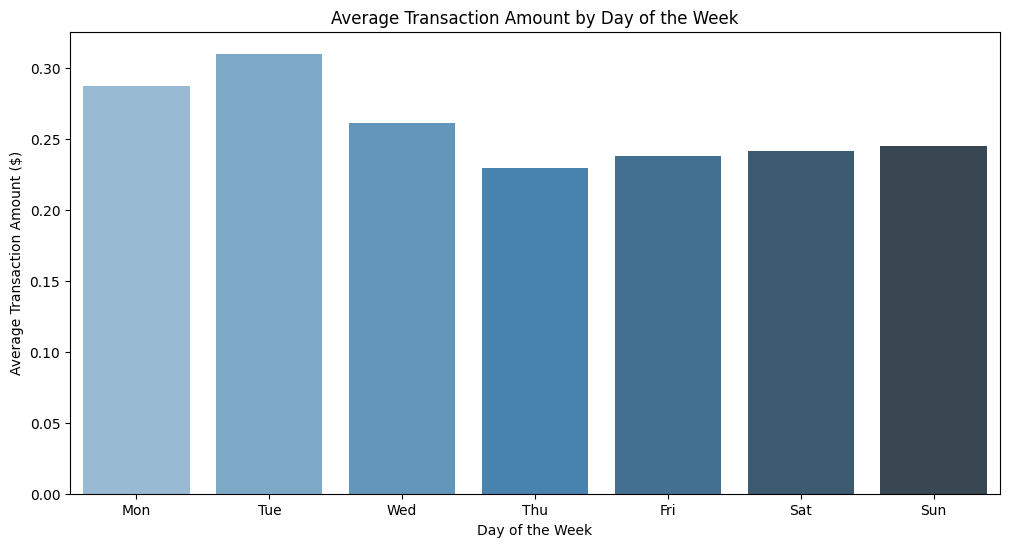

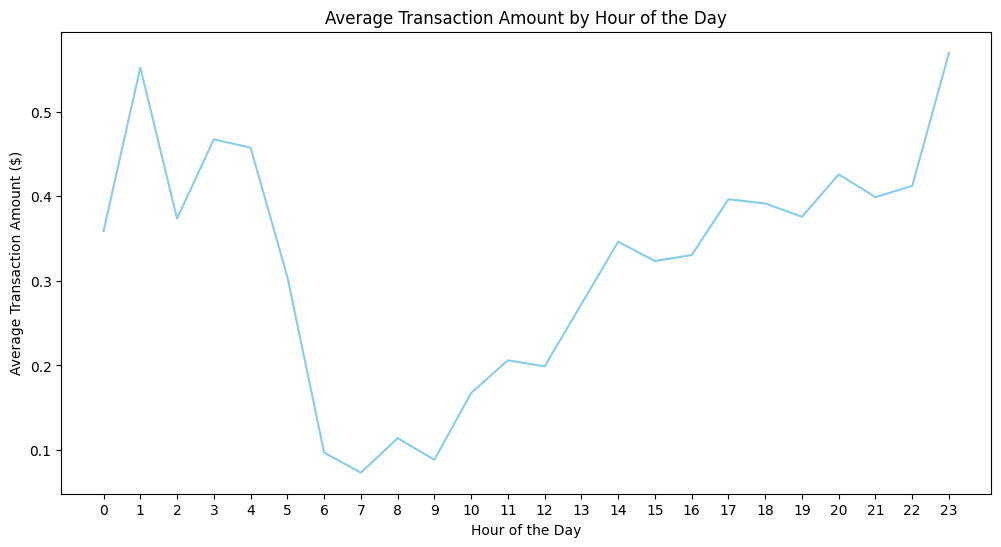

In [16]:
# Function to analyze if day of the week or time affects transaction amount
def analyze_day_time_effect_on_amount(data):
    # Ensure the 'date' column is in datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Extract day of the week (0=Monday, 6=Sunday)
    data['day_of_week'] = data['date'].dt.dayofweek

    print(data[data['day_of_week'] == 5].shape)

    # Extract hour of the day
    data['hour_of_day'] = data['date'].dt.hour

    # Calculate the average transaction amount by day of the week
    avg_amount_by_day = data.groupby('day_of_week')['robust_normalized_amount'].mean()

    #category_counts = data['merchant_category'].value_counts()
       
    # Plot the average transaction amount by day of the week
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_amount_by_day.index, y=avg_amount_by_day.values, palette='Blues_d')
    plt.title('Average Transaction Amount by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Transaction Amount ($)')
    plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()


    # Calculate the average transaction amount by hour of the day
    avg_amount_by_hour = data.groupby('hour_of_day')['robust_normalized_amount'].mean()

    # Plot the average transaction amount by hour of the day
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=avg_amount_by_hour.index, y=avg_amount_by_hour.values, color='skyblue')
    plt.title('Average Transaction Amount by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Transaction Amount ($)')
    plt.xticks(range(0, 24, 1))
    plt.show()

# Call the function with the transactions_data
analyze_day_time_effect_on_amount(data_cleaned)

